# Variable Density Tesseroids tests: Exponential Density

** Import Packages **

In [1]:
from __future__ import division
import numpy as np
from tesseroid_density import tesseroid
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

** Configuration for Pyplot Figures **

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

## Determination of D for exponential density

Now we are going to perform the same tests, but now with an exponential density:

\begin{equation}
\rho(r') = Ae^{-(r'-R)/b} + C
\end{equation}

The analytical solution of the potential generated by a spherical shell with this density function was obtained in the notebook called "02_spherical_shell_variable_density":

\begin{equation}
V_\text{exp}(r) = \frac{4\pi G Ab}{r} 
    e^\frac{\Delta h}{b}
    \left[
    (R_1^2 + 2R_1 b + 2b^2)e^{-\frac{R_1}{b}} -
    (R_2^2 + 2R_2 b + 2b^2)e^{-\frac{R_2}{b}}
    \right] + 
    \frac{4}{3}\pi GC
    \frac{R_2^3 - R_1^3}{r}
\end{equation}

We will perform this test for two cases: a thin shell (1km) and a thick shell (35km).

On both cases we propose that the density functions assumes a value of 2670kg/m$^3$ and 2900kg/m$^3$ at the outer and inner radii, respectively.

We won't apply the density-based discretization algorithm in order to isolate the modified adpative discretization algorithm behaviour.

### Thin Shell

** Definition of analytical solution for spherical shell **

In [3]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [4]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of exponential density function**

In [5]:
rho0, rho1 = 2670, 3300
b = 1e6
a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
c = rho0 - a
deltah = MEAN_EARTH_RADIUS

def density_exp_shifted(height):
    r = height + MEAN_EARTH_RADIUS
    return a*np.exp(-(r - deltah)/b) + c

model.addprop("density", [density_exp_shifted for i in range(model.size)])

**Determination of D for different grids**

In [ ]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/exponential-D/' + field + '-' + grid + '-thin-differences.npz',
                 D_values=D_values, diffs=diffs)

** Plot Results **

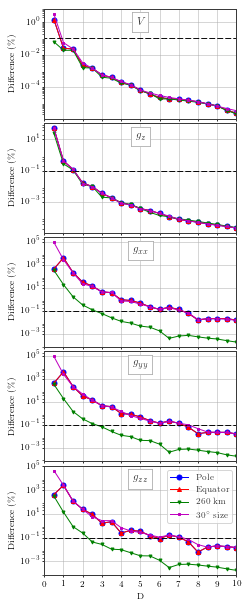

In [7]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/exponential-D/' + field + '-' + 
                        grid + '-thin-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

### Thick Shell

** Definition of analytical solution for spherical shell **

In [8]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [9]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of exponential density function**

In [10]:
rho0, rho1 = 2670, 3300
b = 1e6
a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
c = rho0 - a
deltah = MEAN_EARTH_RADIUS

def density_exp_shifted(height):
    r = height + MEAN_EARTH_RADIUS
    return a*np.exp(-(r - deltah)/b) + c

model.addprop("density", [density_exp_shifted for i in range(model.size)])

**Determination of D for different grids**

In [11]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/exponential-D/' + field + '-' + grid + '-thick-differences.npz',
                 D_values=D_values, diffs=diffs)

tesseroid_density/tesseroid.py:245: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


** Plot Results **

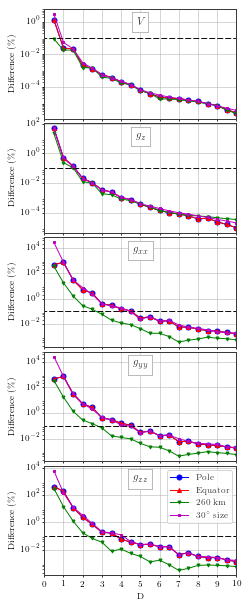

In [13]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/exponential-D/' + field + '-' + 
                        grid + '-thick-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Accuracy vs the constant b in the power

Now we are going to calculate the $gzz$ component for different values of D and different values of the constant $b$ in the power of the density function in order to test how does the accuracy behaves when the exponential density gets steeper.

Again, we won't apply the density-based discretization algorithm.

### Thin Shell

** Definition of analytical solution for spherical shell **

In [14]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [15]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [16]:
shape = (10, 10)
lons, lats, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

**Determination of D for different constants b**

In [17]:
field = 'gzz'
b_values = [1e2, 5*1e2, 1e3, 1e4]
deltah = MEAN_EARTH_RADIUS
D_values = np.arange(0.5, 10.5, 0.5)
rho0, rho1 = 2670, 3300


for b in b_values:
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exp_shifted(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
    diffs = []
    model.addprop("density", [density_exp_shifted for i in range(model.size)])
    for D in D_values:
        result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/exponential-b/' + field + '-' +
             '{:.1e}'.format(b) + '-thin-differences.npz',
             D_values=D_values, diffs=diffs)

**Plot Results**

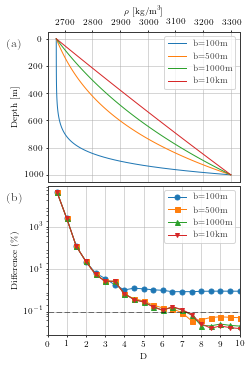

In [20]:
field = 'gzz'
b_values = [1e2, 5*1e2, 1e3, 1e4]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
markers = ["o", "s", "^", "v", "D"]
msize = [5, 5, 5, 4, 3]
labels = [r"b=100m", r"b=500m",
          r"b=1000m", r"b=10km"]
heights = np.linspace(bottom, top, 101)


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches((3.33, 5))

for b, m, ms, label in zip(b_values, markers, msize, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exp_shifted(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exp_shifted(heights), -heights,
             '-', label=label)
    
    diffs = np.load('results/exponential-b/' + field + '-' +
                    '{:.1e}'.format(b) + '-thin-differences.npz')
    D_values, diff = diffs['D_values'], diffs['diffs']
    ax2.plot(D_values, diff, '-', marker=m,
            markersize=ms, label=label)

ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

ax2.plot([0, 10], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax2.set_yscale('log')
ax2.set_yticks(ax2.get_yticks()[2:-2])
ax2.set_ylabel('Difference (\%)')
ax2.grid(True, linewidth=0.5, color='#aeaeae')
ax2.set_axisbelow(True)
ax2.set_xlabel(r"D")
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(0, 11, 1))
ax2.legend(loc=1)
ax2.text(-0.21, 0.9, "(b)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax2.transAxes)

plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

### Thick Shell

** Definition of analytical solution for spherical shell **

In [21]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [22]:
top, bottom = 0, -35000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [23]:
shape = (10, 10)
lons, lats, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

**Determination of D for different constants b**

In [ ]:
field = 'gzz'
b_values = [10e3, 35e3, 100e3, 1000e3]
deltah = MEAN_EARTH_RADIUS
D_values = np.arange(0.5, 10.5, 0.5)
rho0, rho1 = 2670, 3300


for b in b_values:
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exp_shifted(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
    diffs = []
    model.addprop("density", [density_exp_shifted for i in range(model.size)])
    for D in D_values:
        result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D, delta=None)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/exponential-b/' + field + '-' +
             '{:.1e}'.format(b) + '-thick-differences.npz',
             D_values=D_values, diffs=diffs)

**Plot Results**

In [ ]:
field = 'gzz'
b_values = [10e3, 35e3, 100e3, 1000e3]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
markers = ["o", "s", "^", "v", "D"]
msize = [5, 5, 5, 4, 3]
labels = [r"b=10km", r"b=35km",
          r"b=100km", r"b=1000km"]
heights = np.linspace(bottom, top, 101)


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches((3.33, 5))

for b, m, ms, label in zip(b_values, markers, msize, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exp_shifted(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exp_shifted(heights), -heights,
             '-', label=label)
    
    diffs = np.load('results/exponential-b/' + field + '-' +
                    '{:.1e}'.format(b) + '-thick-differences.npz')
    D_values, diff = diffs['D_values'], diffs['diffs']
    ax2.plot(D_values, diff, '-', marker=m,
            markersize=ms, label=label)

ax1.legend()
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(-0.21, 0.9, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)

ax2.plot([0, 10], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax2.set_yscale('log')
ax2.set_yticks(ax2.get_yticks()[2:-2])
ax2.set_ylabel('Difference (\%)')
ax2.grid(True, linewidth=0.5, color='#aeaeae')
ax2.set_axisbelow(True)
ax2.set_xlabel(r"D")
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(0, 11, 1))
ax2.legend(loc=1)
ax2.text(-0.21, 0.9, "(b)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax2.transAxes)

plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Determination of delta

We are going to perform a test to determine the maximum value of delta needed to achieve a good accuracy.
In order to do this we are going to compute the differences between the numerical model and the analytical solution for several values of delta, and for different values of $b$.

We are going to plot one curve por each value of $b$ in a Difference vs delta graph.

### Thin Shell

** Definition of analytical solution for spherical shell **

In [ ]:
def shell_exponential_density(height, top, bottom, a, b, c, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-(r1 - deltah)/b) -
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-(r2 - deltah)/b))
    constant += 4/3*np.pi*G*c*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [ ]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [ ]:
shape = (10, 10)
lons, lats, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

** Compute the differences **

In [ ]:
field = 'gzz'
b_values = [1e2, 5*1e2, 1e3, 1e4]
deltah = MEAN_EARTH_RADIUS
delta_values = np.array([0.15, 0.2, 0.25, 0.3])
rho0, rho1 = 2670, 3300


for b in b_values:
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exp_shifted(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    analytical = shell_exponential_density(heights[0], top, bottom, a, b, c, deltah)
    diffs = []
    model.addprop("density", [density_exp_shifted for i in range(model.size)])
    for delta in delta_values:
        result = getattr(tesseroid, field)(lons, lats, heights, model, delta=delta)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/exponential-delta/' + field + '-' +
             '{:.1e}'.format(b) + 'thin-differences.npz',
             deltas=delta_values, diffs=diffs)